In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# For Vision Transformer
from vit_pytorch import ViT

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [9]:
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images organized in subfolders by class
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all classes (subdirectories)
        self.classes = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Collect all image paths with their corresponding labels
        self.image_paths = []
        self.labels = []
        
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for ViT
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [13]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT typically uses 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transform)
val_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/val', transform=val_test_transform)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=val_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624
Number of classes: 2
Class names: ['NORMAL', 'PNEUMONIA']


In [14]:
# Initialize Vision Transformer model
num_classes = len(train_dataset.classes)

model = ViT(
    image_size=224,
    patch_size=32,          # 224/32 = 7 patches per dimension (49 total)
    num_classes=num_classes,
    dim=1024,               # Embedding dimension
    depth=6,                # Number of transformer layers
    heads=16,               # Number of attention heads
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model moved to {device}")

Model moved to cuda


In [15]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training parameters
num_epochs = 20
best_val_loss = float('inf')
best_model_path = 'best_vit_model.pth'

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)
        
        # Save best model
        global best_val_loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with val loss: {best_val_loss:.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    return train_losses, val_losses, train_accs, val_accs

# Start training
print("Starting training...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

Starting training...
New best model saved with val loss: 0.4007
Epoch 1/20: Train Loss: 0.3584, Train Acc: 0.8566 | Val Loss: 0.4007, Val Acc: 0.8125
Epoch 2/20: Train Loss: 0.1643, Train Acc: 0.9337 | Val Loss: 0.7180, Val Acc: 0.7500
Epoch 3/20: Train Loss: 0.1338, Train Acc: 0.9477 | Val Loss: 0.4567, Val Acc: 0.7500
Epoch 4/20: Train Loss: 0.1425, Train Acc: 0.9423 | Val Loss: 0.8878, Val Acc: 0.7500
Epoch 5/20: Train Loss: 0.1341, Train Acc: 0.9519 | Val Loss: 0.4172, Val Acc: 0.7500
New best model saved with val loss: 0.3351
Epoch 6/20: Train Loss: 0.0991, Train Acc: 0.9622 | Val Loss: 0.3351, Val Acc: 0.8125
New best model saved with val loss: 0.2982
Epoch 7/20: Train Loss: 0.0872, Train Acc: 0.9688 | Val Loss: 0.2982, Val Acc: 0.8125
New best model saved with val loss: 0.2419
Epoch 8/20: Train Loss: 0.0825, Train Acc: 0.9689 | Val Loss: 0.2419, Val Acc: 0.8125
Epoch 9/20: Train Loss: 0.0787, Train Acc: 0.9678 | Val Loss: 0.4176, Val Acc: 0.8125
Epoch 10/20: Train Loss: 0.0815, 

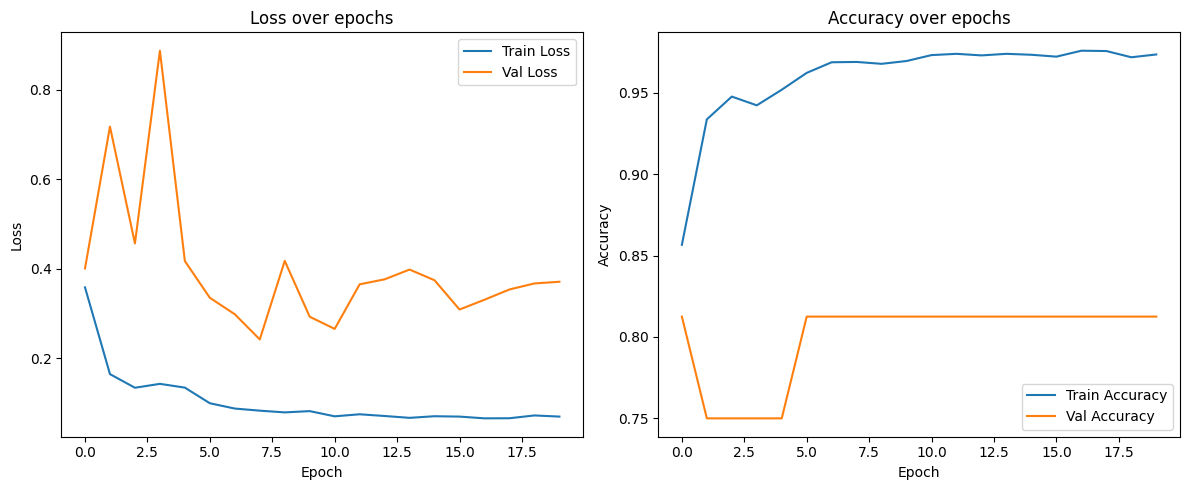

In [17]:
def plot_training_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, val_losses, train_accs, val_accs)

Evaluating on test set with best model...


<ipython-input-18-ff69cb6ee998>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.9058, Test Accuracy: 0.7692

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.41      0.57       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



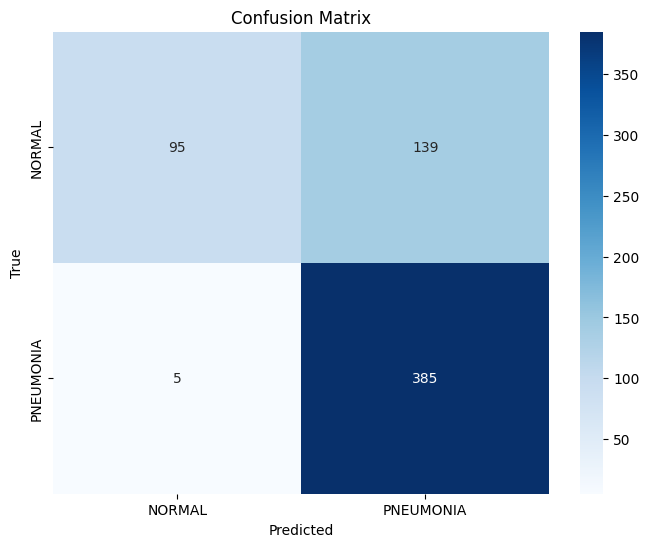

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = correct / total
        
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=train_dataset.classes, 
                    yticklabels=train_dataset.classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Load best model
model.load_state_dict(torch.load(best_model_path))
print("Evaluating on test set with best model...")
evaluate_model(model, test_loader)